In [3]:
import librosa
import numpy as np
import glob
import yaml

# config.yaml 로드
with open("./config/config.yaml") as f:
    config = yaml.safe_load(f)

sr = config["data"]["sample_rate"]
n_mels = config["data"]["n_mels"]
segment_frames = config["data"]["segment_frames"]
max_samples = config["data"]["max_samples"]



In [4]:
def extract_mel_features(wav_path):
    y, _ = librosa.load(wav_path, sr=sr)

    mel = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_mels=n_mels
    )
    mel = librosa.power_to_db(mel)

    # (n_mels, time) → (time, n_mels)
    mel = mel.T

    # segment_frames 길이로 자르기
    if mel.shape[0] >= segment_frames:
        mel = mel[:segment_frames]
    else:
        pad = segment_frames - mel.shape[0]
        mel = np.pad(mel, ((0, pad), (0, 0)))

    return mel.flatten()  # 1D 벡터


In [8]:
def load_dataset(path, label, max_samples):
    files = glob.glob(f"{path}/**/*.wav", recursive=True)
    files += glob.glob(f"{path}/**/*.flac", recursive=True)
    files = files[:max_samples]

    X, y = [], []

    for f in files:
        feat = extract_mel_features(f)
        if feat.size == 0:
            continue
        X.append(feat)
        y.append(label)

    return np.array(X), np.array(y)


X_normal, y_normal = load_dataset(
    config["data"]["train_clean_path"], label=0, max_samples=max_samples
)

X_anom, y_anom = load_dataset(
    config["data"]["test_anomaly_path"], label=1, max_samples=max_samples
)


In [11]:
print(len(glob.glob(f"{config['data']['train_clean_path']}/**/*.flac", recursive=True)))
print(len(glob.glob(f"{config['data']['test_anomaly_path']}/**/*.wav", recursive=True)))


28539
13100


/opt/anaconda3/envs/deepvoice/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/anaconda3/envs/deepvoice/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/anaconda3/envs/deepvoice/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/anaconda3/envs/deepvoice/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/anaconda3/envs/deepvoice/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/anaconda3/envs/deepvoice/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A.T

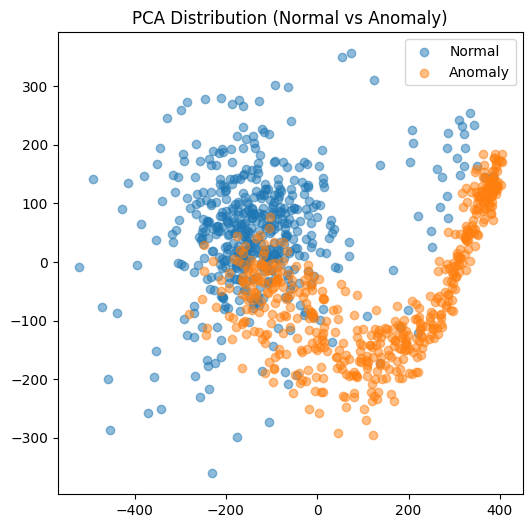

/opt/anaconda3/envs/deepvoice/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/anaconda3/envs/deepvoice/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/anaconda3/envs/deepvoice/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/anaconda3/envs/deepvoice/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/anaconda3/envs/deepvoice/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/anaconda3/envs/deepvoice/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A.T

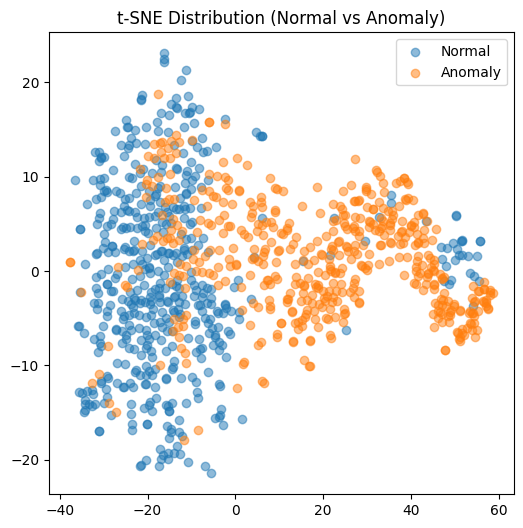

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X = np.vstack([X_normal, X_anom])
y = np.hstack([y_normal, y_anom])

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(6, 6))
plt.scatter(X_pca[y==0, 0], X_pca[y==0, 1], alpha=0.5, label="Normal")
plt.scatter(X_pca[y==1, 0], X_pca[y==1, 1], alpha=0.5, label="Anomaly")
plt.legend()
plt.title("PCA Distribution (Normal vs Anomaly)")
plt.show()

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(6, 6))
plt.scatter(X_tsne[y==0, 0], X_tsne[y==0, 1], alpha=0.5, label="Normal")
plt.scatter(X_tsne[y==1, 0], X_tsne[y==1, 1], alpha=0.5, label="Anomaly")
plt.legend()
plt.title("t-SNE Distribution (Normal vs Anomaly)")
plt.show()

